# Churn rate study

This study was conducted for the network of gym centers, which develops a strategy for interacting with clients based on analytical data.

The purpose of the study is to analyze the customer churn rate and prepare an action plan for retaining clients.

**Research objectives:**

- learn to predict the probability of churn (at the level of the next month) for each client;
- form typical portraits of clients: identify several of the most striking groups and characterize their main properties;
- analyze the main features that most strongly affect churn;
- formulate the main conclusions and develop recommendations for improving the quality of work with clients:

1) identify target groups of clients;
2) propose measures to reduce churn;
3) determine other features of interaction with clients.

The data contains data for the month before the churn and the fact of churn for a certain month. The data set includes the following fields:
Customer data for the month preceding the churn fact check:

- 'gender' — gender;
- 'Near_Location' — residence or work in the area where the fitness center is located;
- 'Partner' — employee of the club's partner company (cooperation with companies whose employees can receive discounts on membership — in this case, the fitness center stores information about the client's employer);
- Promo_friends — fact of initial registration as part of the "bring a friend" promotion (used a promo code from a friend when paying for the first membership);
- 'Phone' — availability of a contact phone number;
- 'Age' — age;
- 'Lifetime' — time since the first visit to the fitness center (in months).

Information based on the visit log, purchases and information about the current status of the client's membership:

- 'Contract_period' — duration of the current membership (month, 6 months, year);
- 'Month_to_end_contract' — time left on the current membership (in months);
- 'Group_visits' — fact of visiting group classes;
- 'Avg_class_frequency_total' — average frequency of visits per week for the entire period since the membership began;
- 'Avg_class_frequency_current_month' — average frequency of visits per week for the previous month;
- 'Avg_additional_charges_total' — total revenue from other fitness center services: cafe, sporting goods, beauty and massage salon.
- 'Churn' — fact of churn in the current month.

In [25]:
#import libraries
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage 

In [26]:
from io import BytesIO
import requests
spreadsheet_id = '1GsbI_0N2NXZ66eBfzHJLlYiG6-QwPcYAEe-KO9ZtdD8'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
dt = pd.read_csv(BytesIO(r.content))
dt.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


In [3]:
display(dt.info())
display(dt.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int64  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


## Exploratory Data Analysis

In [4]:
print('Number of duplicates:')
display(dt.duplicated().sum())
print ()
print('Number of missing values:')
display(dt.isna().sum())



Number of duplicates:


0


Number of missing values:


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

The data is ready for work - there are no missing values, duplicates or incorrect data formats.

In [5]:
display(dt.describe())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:

dt_churn = dt.groupby('Churn').agg('mean')
dt_churn

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


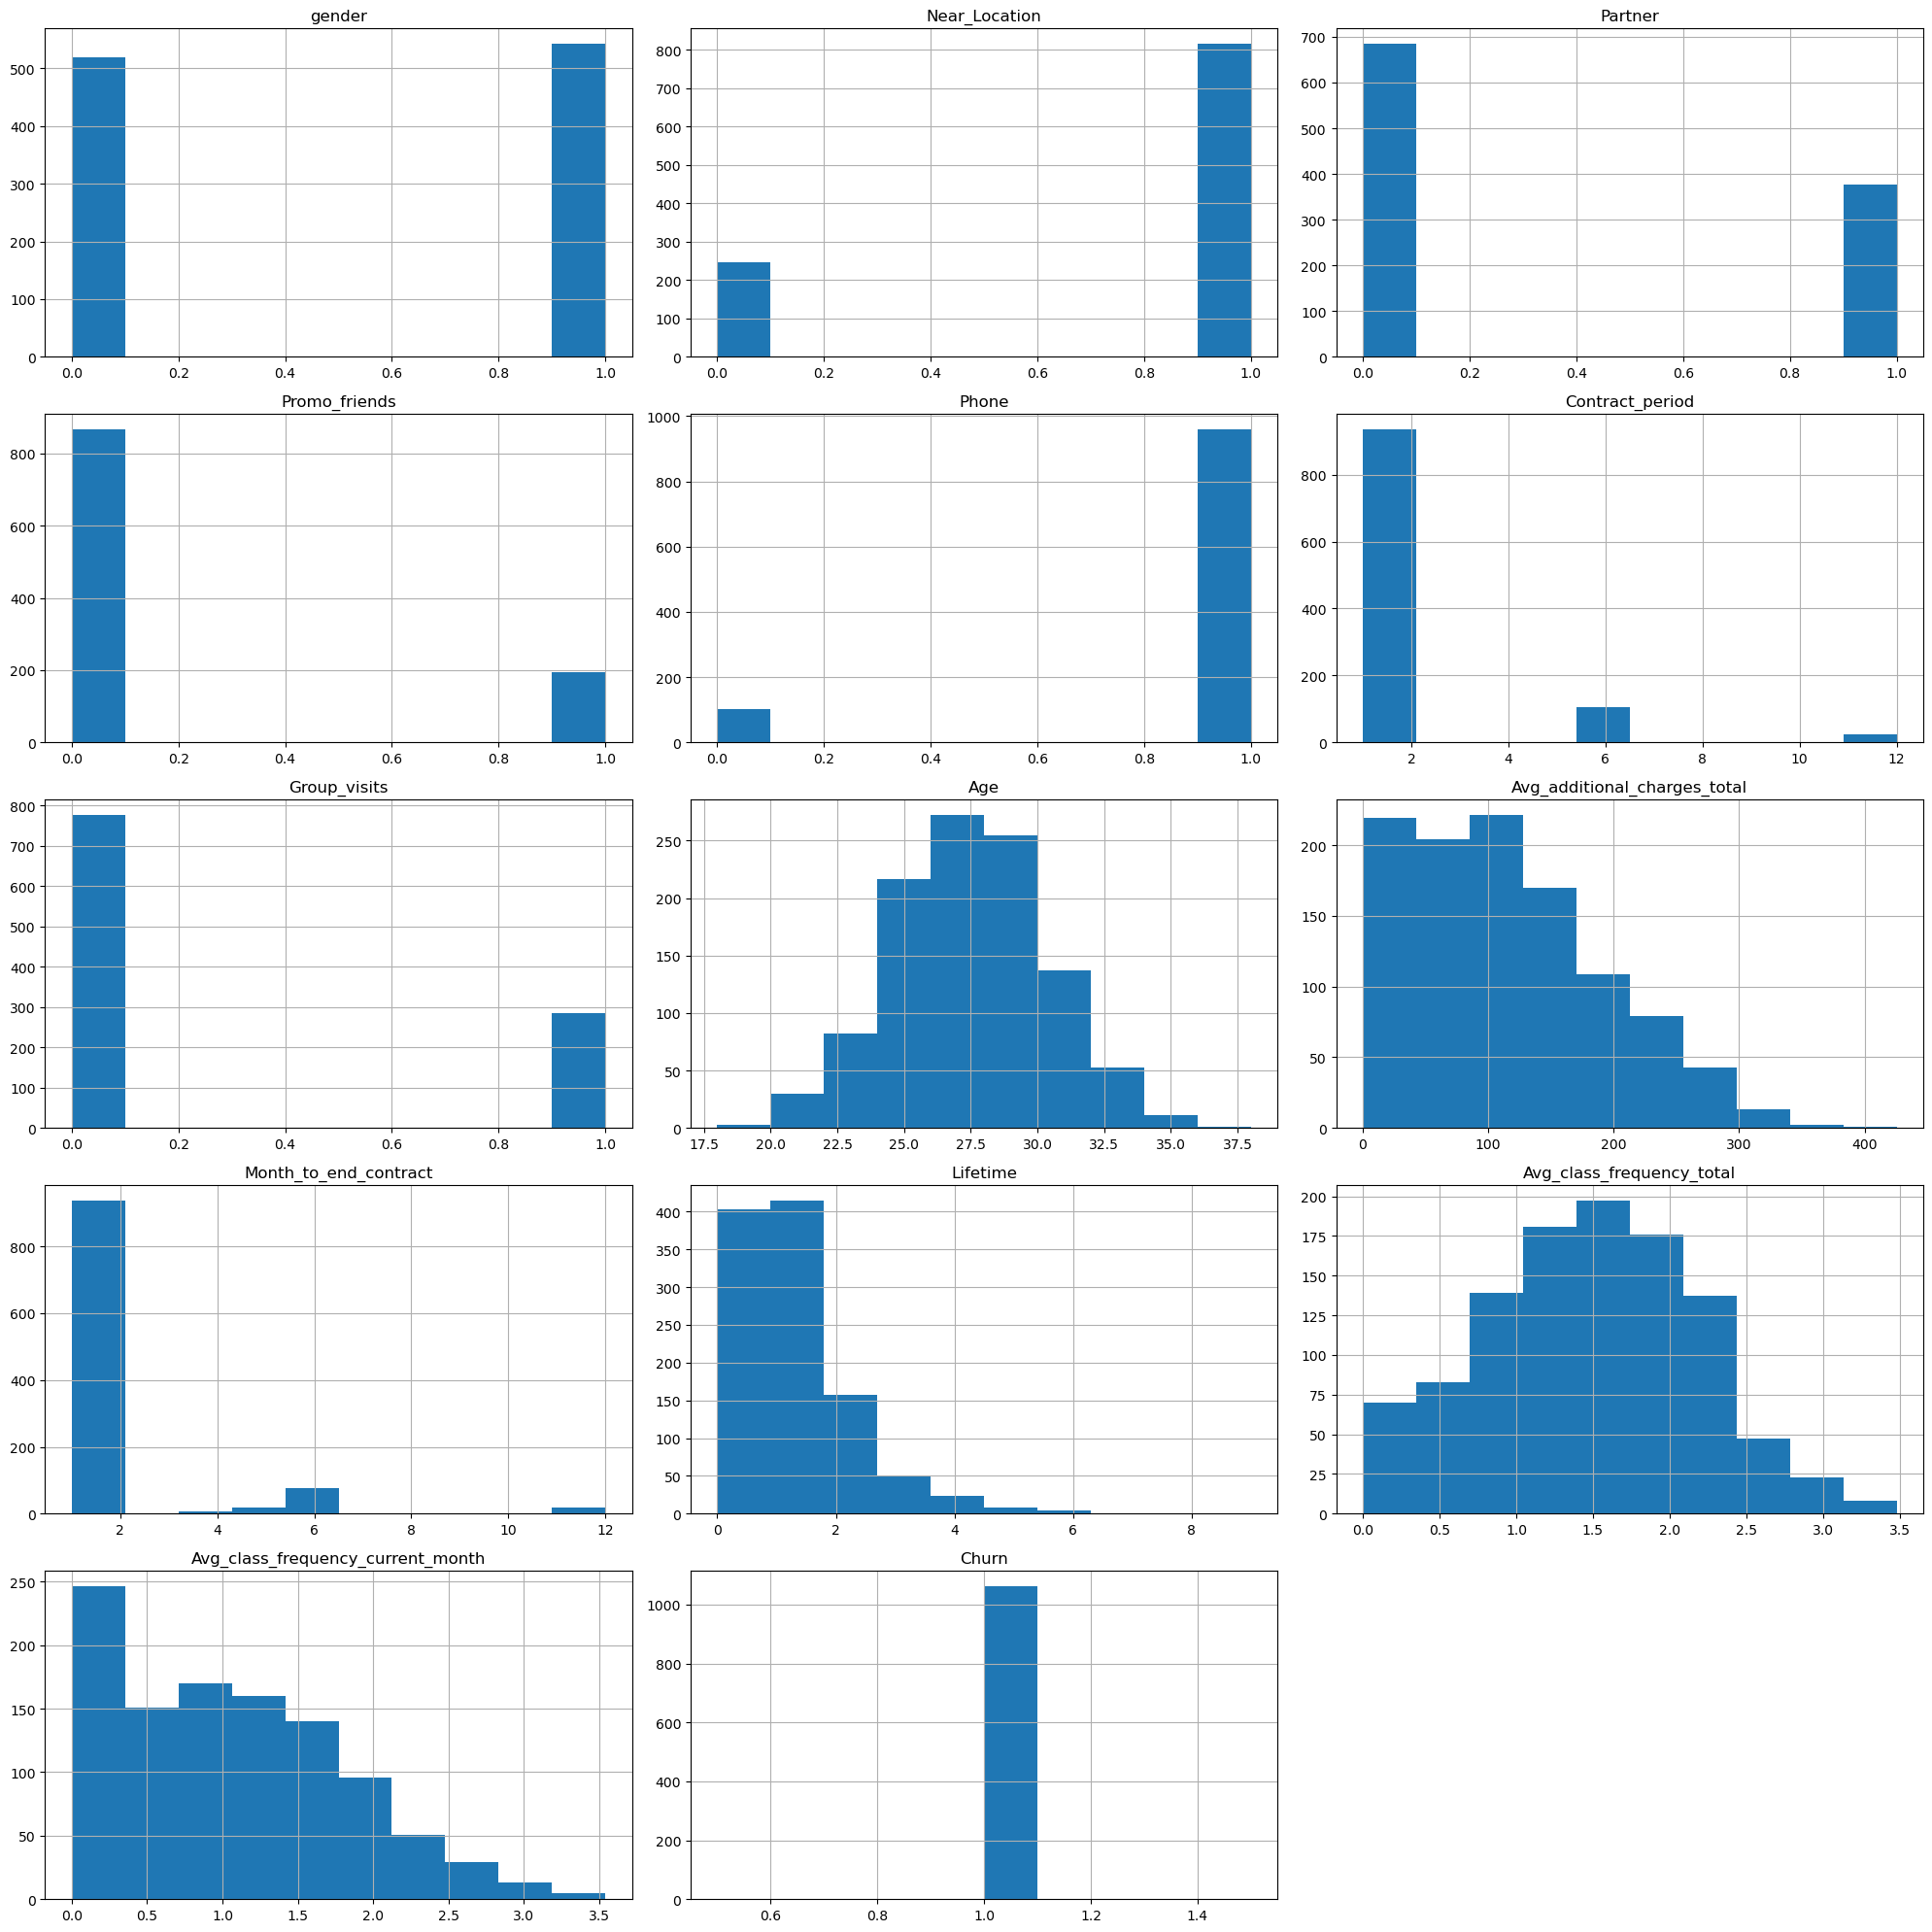

In [7]:
# mean values for users who left
dt_churn_1 = dt.query('Churn == 1')
dt_churn_1.hist(figsize=(20, 20), layout=(5, 3))
plt.tight_layout()
plt.show()



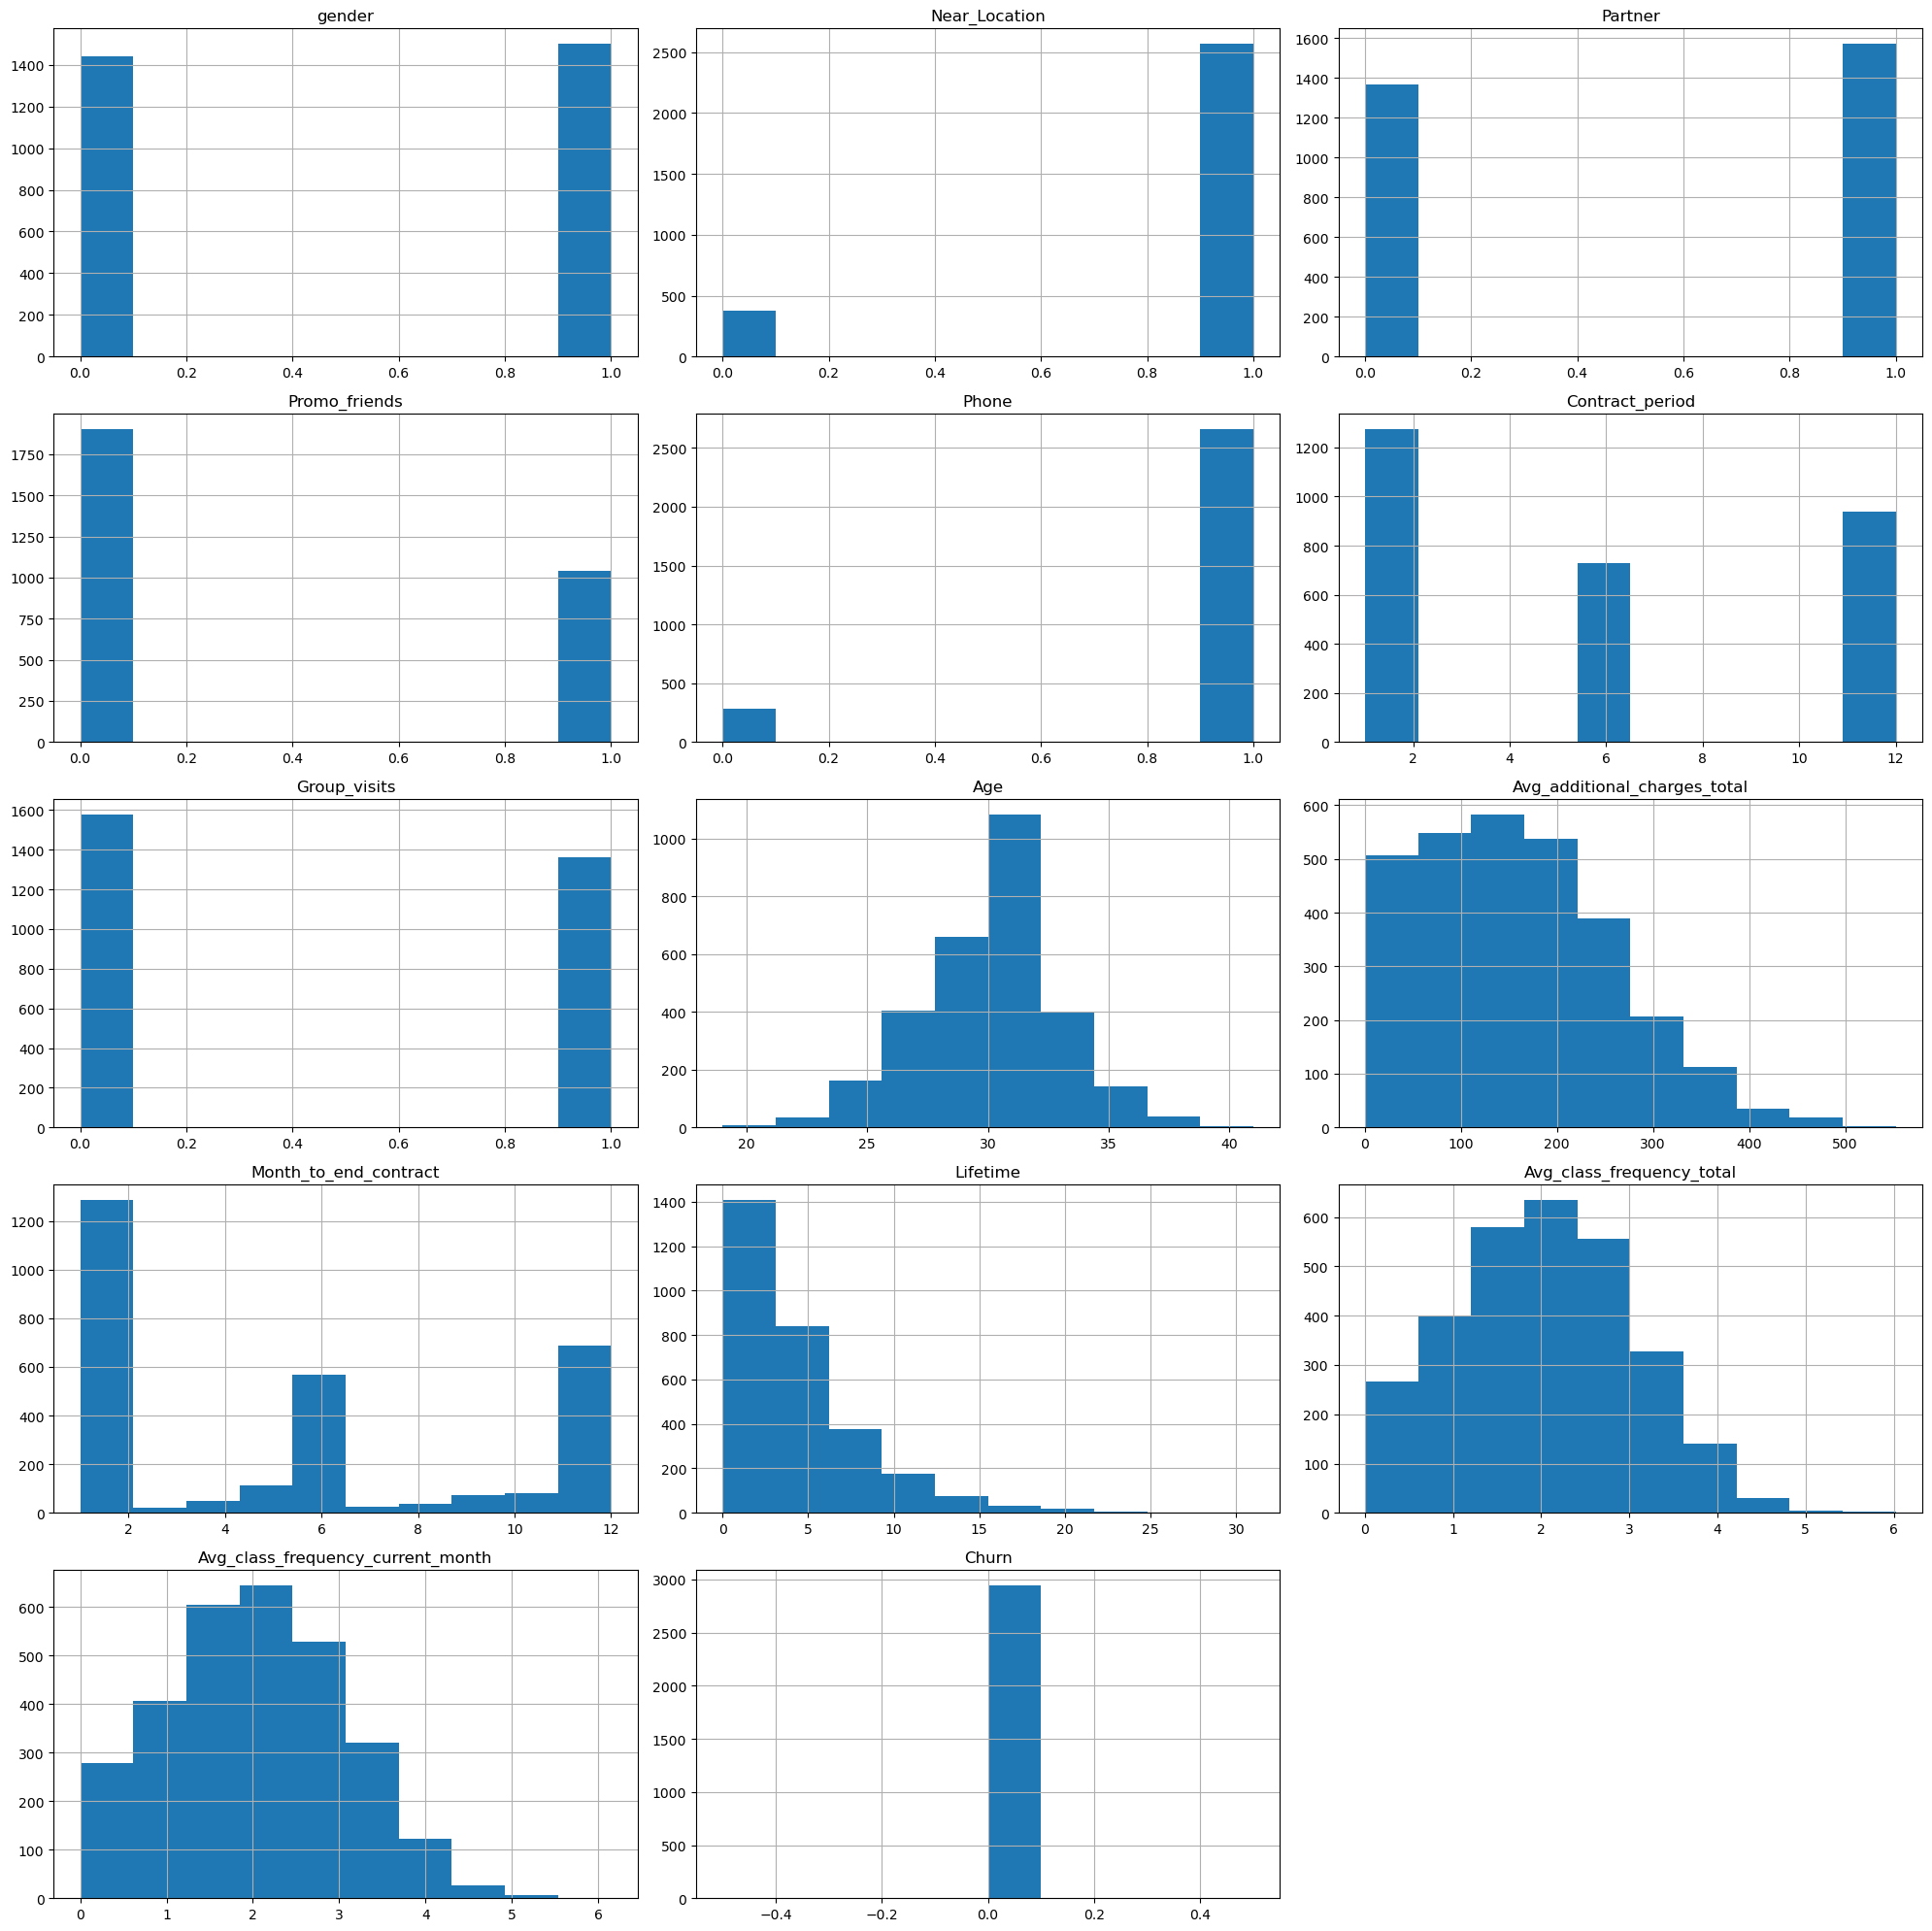

In [8]:
# mean values for users who stayed
dt_churn_0 = dt.query('Churn == 0')
dt_churn_0.hist(figsize=(20, 20), layout=(5, 3))
plt.tight_layout()
plt.show()


In [9]:
#Pearson correlation
dt.corr()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


In [10]:
%pip install phik


Note: you may need to restart the kernel to use updated packages.


In [11]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [12]:
#Spearman's rank correlation coefficient
phik_overview = dt.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Churn']


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00
Near_Location,0.00,1.00,0.00,0.32,0.00,0.09,0.24,0.07,0.12,0.19,0.06,0.06,0.07,0.20
Partner,0.00,0.00,1.00,0.65,0.00,0.19,0.02,0.06,0.03,0.39,0.10,0.00,0.02,0.24
Promo_friends,0.00,0.32,0.65,1.00,0.00,0.15,0.19,0.06,0.07,0.33,0.10,0.04,0.06,0.25
Phone,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00
Contract_period,0.00,0.09,0.19,0.15,0.00,1.00,0.10,0.16,0.14,0.97,0.20,0.15,0.18,0.25
Group_visits,0.01,0.24,0.02,0.19,0.00,0.10,1.00,0.09,0.05,0.22,0.10,0.07,0.09,0.27
Age,0.00,0.07,0.06,0.06,0.00,0.16,0.09,1.00,0.08,0.13,0.16,0.15,0.21,0.52
Avg_additional_charges_total,0.00,0.12,0.03,0.07,0.00,0.14,0.05,0.08,1.00,0.13,0.01,0.09,0.06,0.26
Month_to_end_contract,0.00,0.19,0.39,0.33,0.00,0.97,0.22,0.13,0.13,1.00,0.23,0.18,0.19,0.52


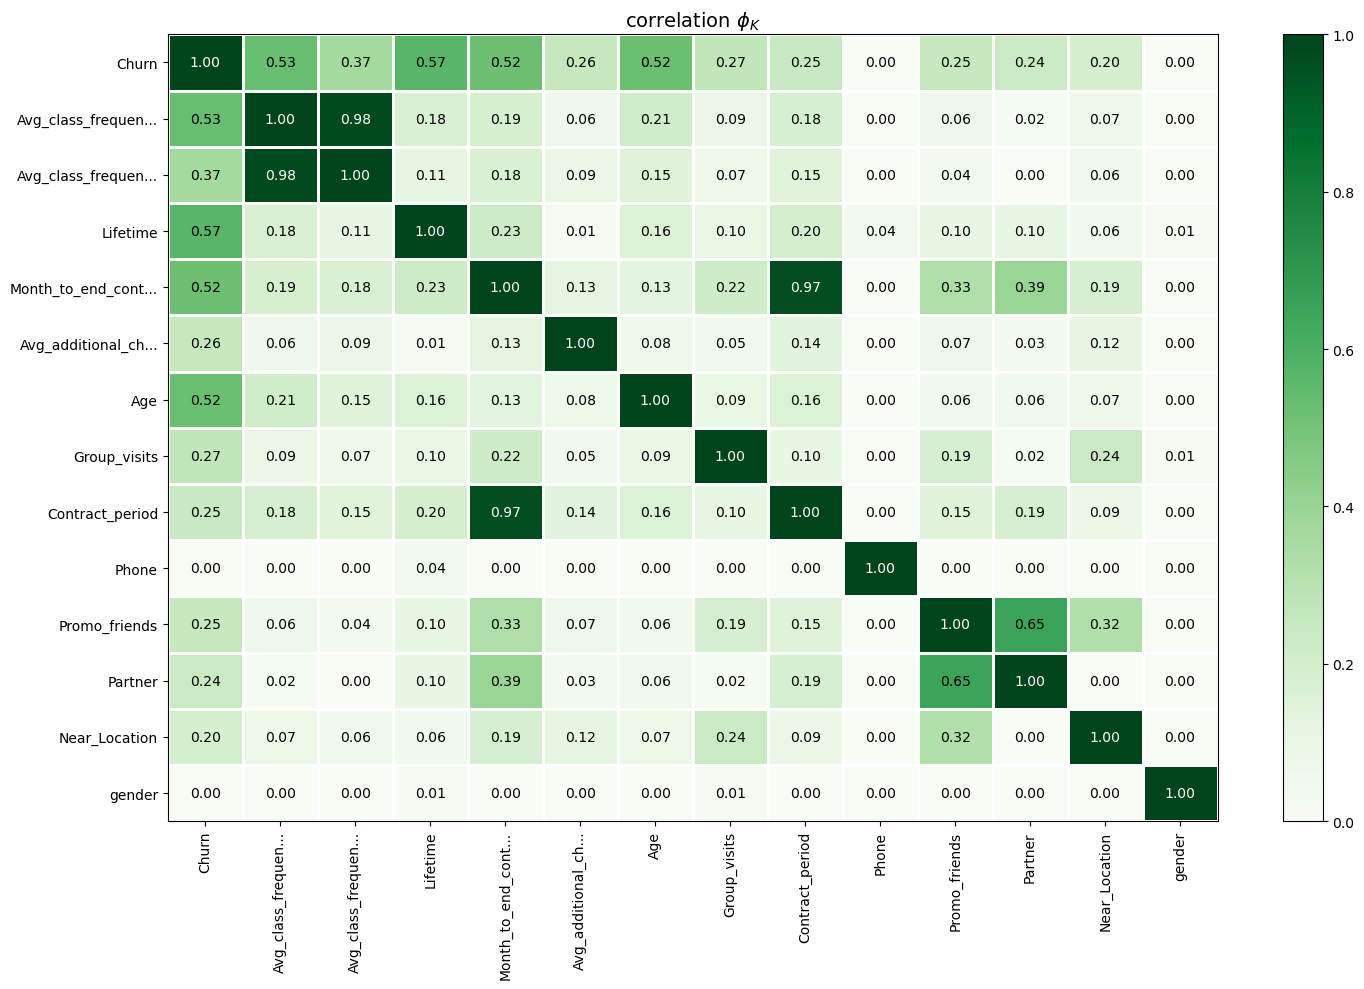

In [13]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))
plt.tight_layout()

## Section summary

For exploratory data analysis, I looked at the histograms of the distribution of features for users who left the gym and those who stayed, and also looked at the Pearson and Spearman correlations. I made several conclusions:

- the distribution of the proximity indicator among those who left and those who stayed is approximately the same
- among those who left, there are fewer employees - partner companies of the gym than among those who stayed
- the average age of those who left is less than among those who stayed
- the highest correlation is for the Churn  with the features Avg_class_frequency_total, Lifetime, Age and Month_to_end_contract

Based on the data, I conclude that when working with outgoing clients, it is necessary to pay attention primarily to those who come often and whose membership is ending soon - perhaps it is worth offering them favorable terms for renewal of the membership.

In [14]:
# 
X = dt.drop(columns=['Churn'])
y = dt['Churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [15]:
model= LogisticRegression(solver='liblinear') 

In [16]:
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [17]:
predictions = model.predict(X_test) 
probabilities = model.predict_proba(X_test)[:,1]

In [18]:
# show metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))


Accuracy: 0.93
Precision: 0.86
Recall: 0.83


In [19]:

rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:,1]


In [20]:
# show metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


Показатели незначительно выше у модели логистической регрессии, то есть она работает лучше.

In [21]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

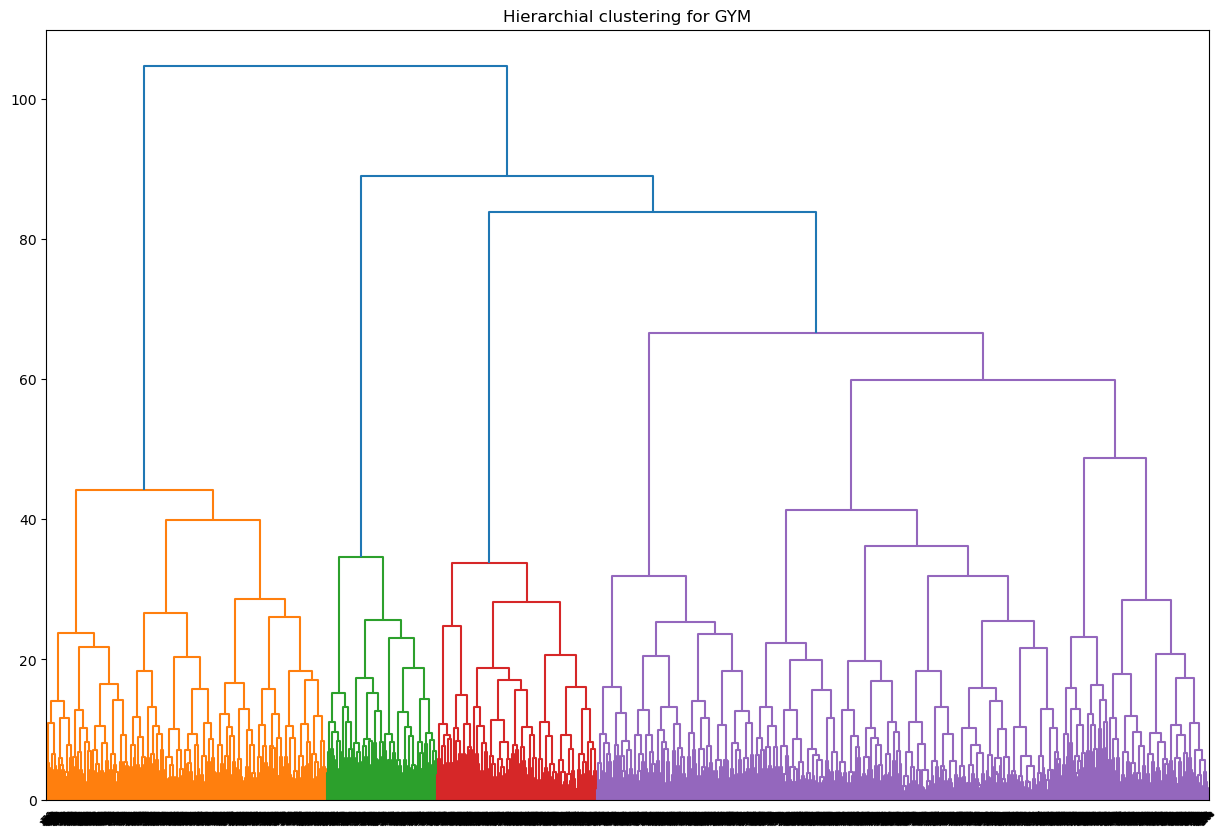

In [22]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.xticks(rotation=45)
plt.show() 

In [23]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

dt['cluster_km'] = km


cluster_km = dt.groupby(by=['cluster_km']).mean()
display (cluster_km)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
"KMeans(n_clusters=5, random_state=0)",0.51025,0.84525,0.48675,0.3085,0.9035,4.68125,0.41225,29.18425,146.943728,4.32275,3.72475,1.87902,1.767052,0.26525


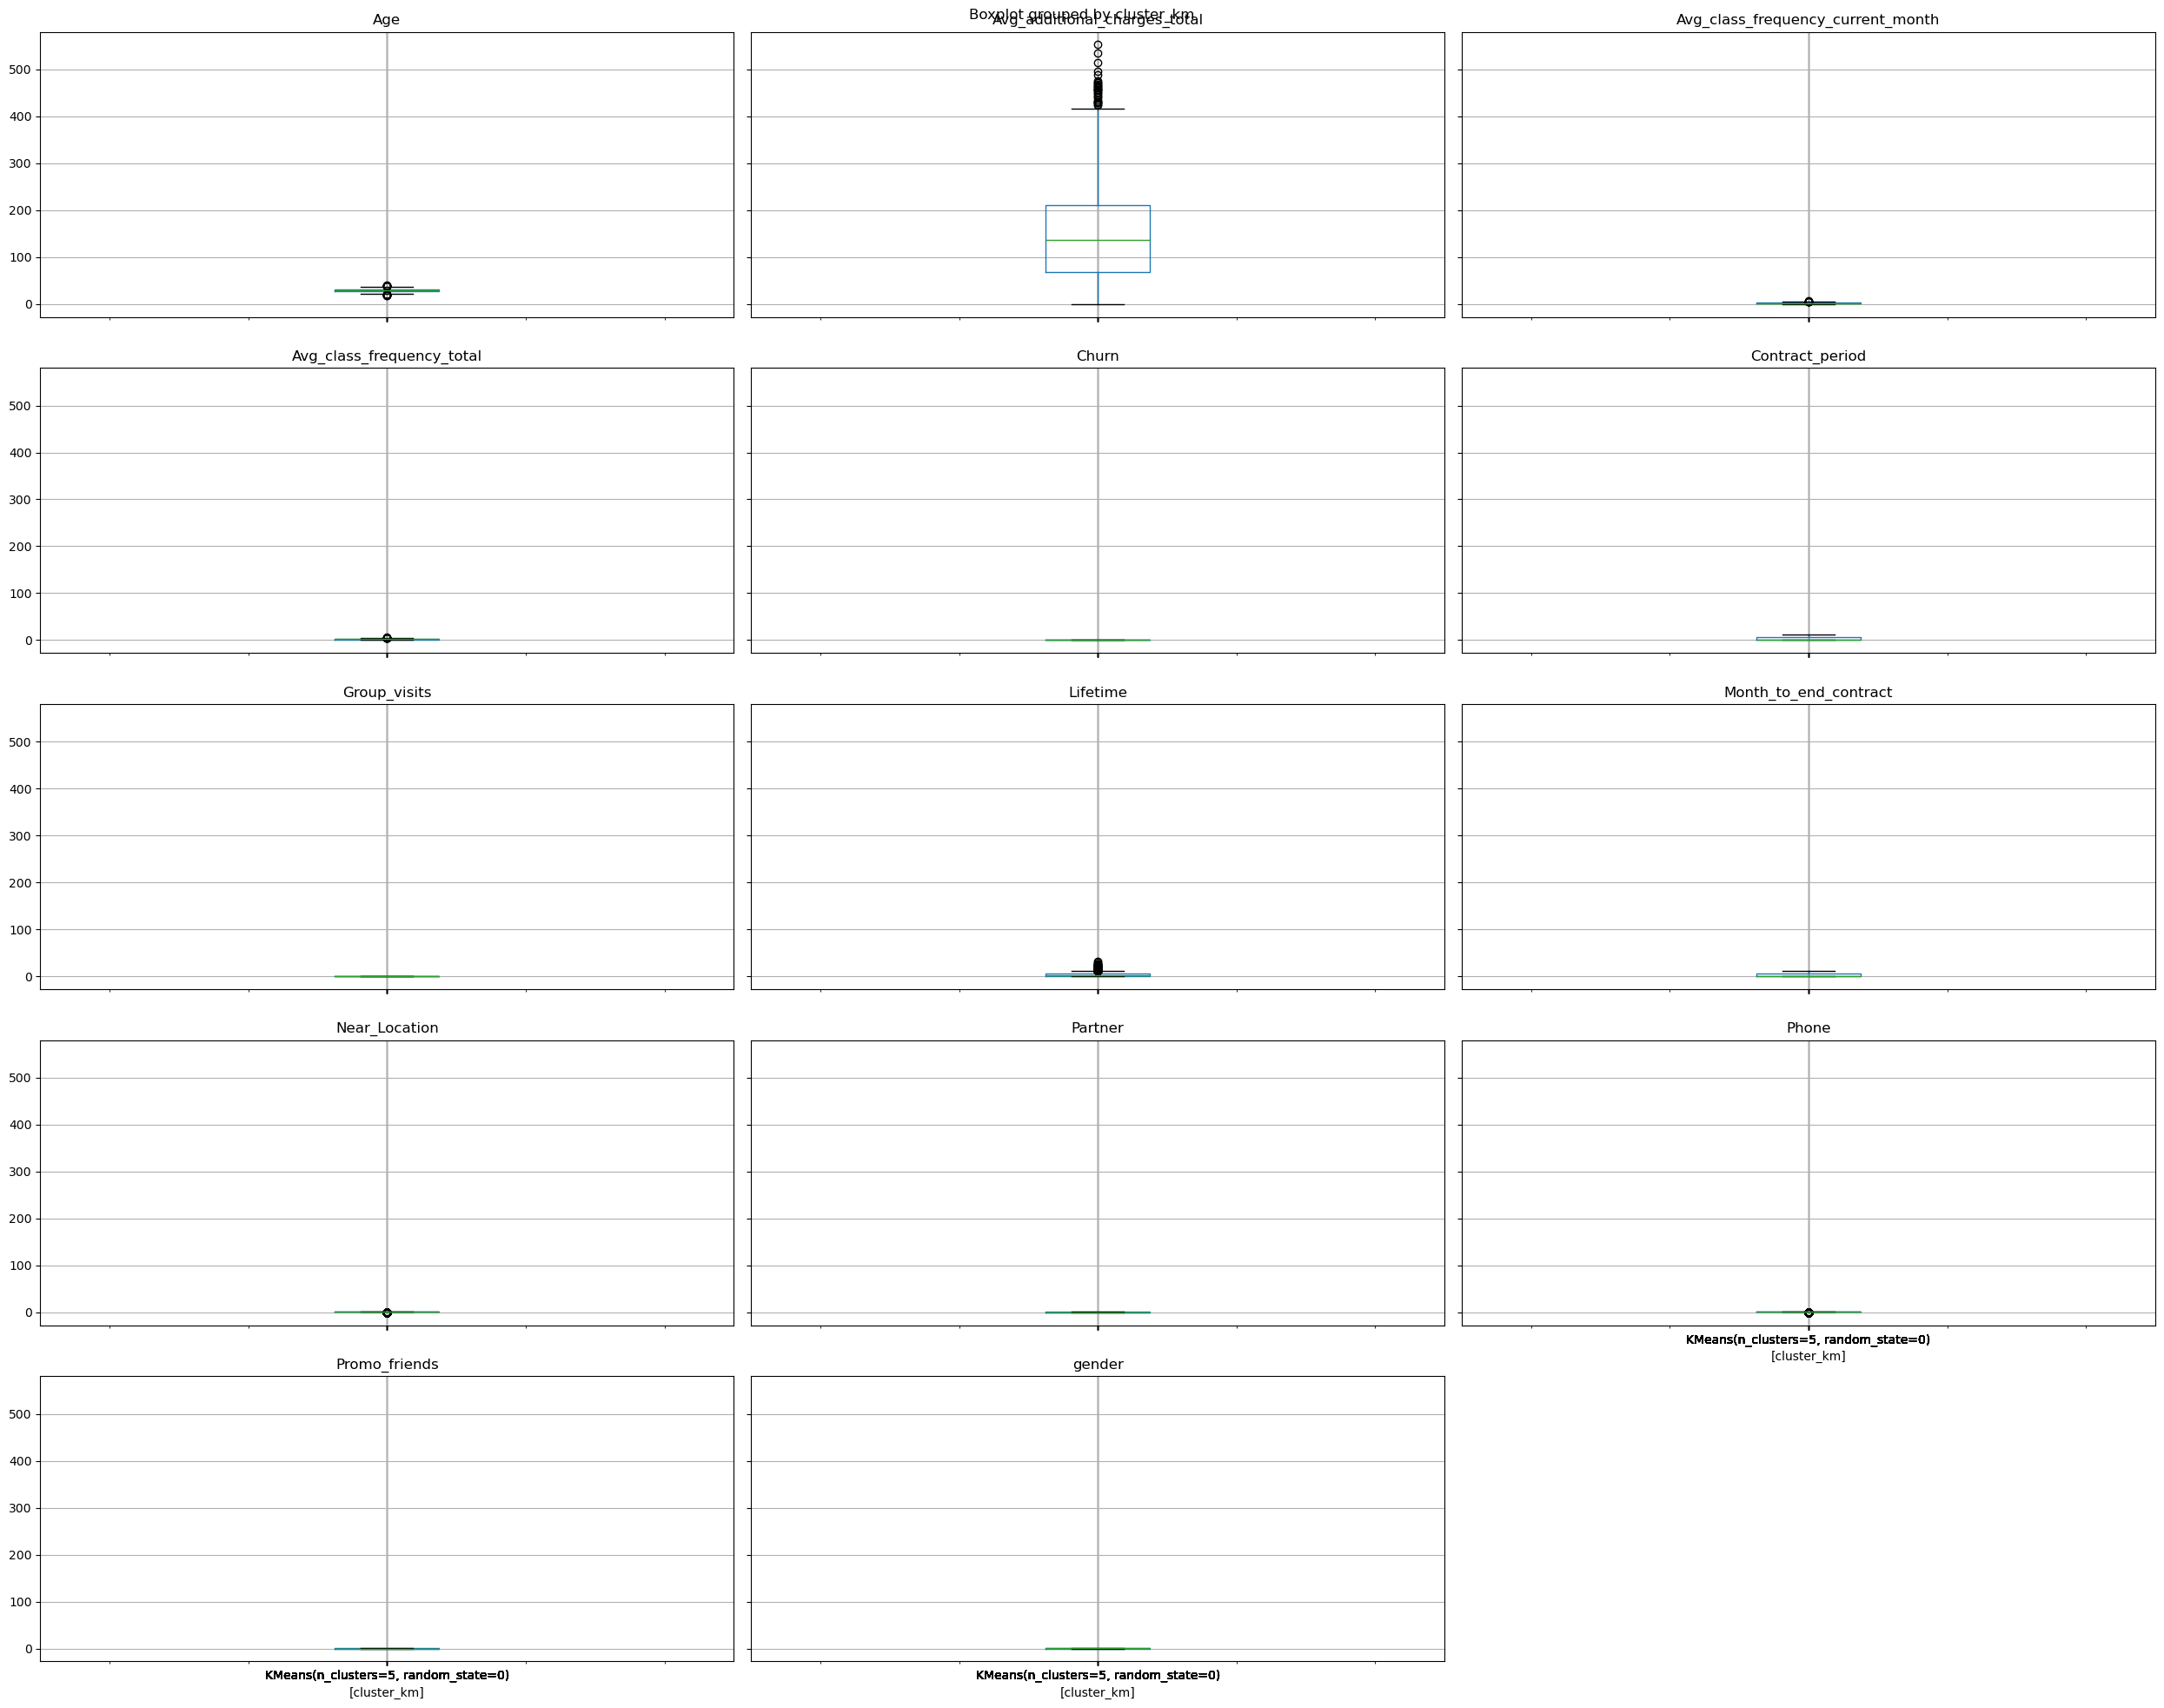

In [24]:
dt.boxplot(by ='cluster_km',figsize=(25,20), layout=(5, 3))
plt.ylim(-100, 200)
plt.tight_layout()
plt.show()

# Section summary
To conduct the analysis, the data was divided into a validation and training sample in a ratio of 80 to 20. Two models were used in the analysis - logistic regression and random forest.
In both cases, the accuracy, precision and recall metrics showed good results - all indicators are greater than 0.8, which is close to one and means that the models correctly, completely and accurately predict more than 80% of responses.

When constructing the dendrogram, I identified 5 clusters.
The pairwise graphs show that users who often visit the gym and use other services of the gym overlap strongly with each other. It is also clear that old users and users who often visit the gym also overlap.


